<a href="https://colab.research.google.com/github/Khislatz/DS-Unit-1-Sprint-2-Statistics/blob/master/Khislat_Zhuraeva_LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


# Generate and numerically represent a confidence interval

In [0]:
import pandas as pd
from scipy.stats import t, ttest_ind, ttest_1samp
import numpy as np  
import math
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

In [177]:
#get the raw data
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-02-02 22:00:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.2’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.04s   

2020-02-02 22:00:44 (479 KB/s) - ‘house-votes-84.data.2’ saved [18171/18171]



In [0]:
#make it into a dataframe 

column_headers = ['party','handicapped-infants', 'water-project', 'budget', 'physician-fee-freeze',
               'el-salvador-aid','religious-groups', 'anti-satellite-test-ban', 'aid-to-contras',
               'mx-missile', 'immigration', 'synfuels', 'education', 'right-to-sue', 'crime',
               'duty-free', 'south-africa']


In [179]:
df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=column_headers,
                 na_values='?')
df.shape

(435, 17)

In [180]:
#Remove all the null values 
df.isnull().sum()

party                        0
handicapped-infants         12
water-project               48
budget                      11
physician-fee-freeze        11
el-salvador-aid             15
religious-groups            11
anti-satellite-test-ban     14
aid-to-contras              15
mx-missile                  22
immigration                  7
synfuels                    21
education                   31
right-to-sue                25
crime                       17
duty-free                   28
south-africa               104
dtype: int64

In [0]:
#dropping missing values
df = df.dropna(how='any')

In [182]:
df.shape

(232, 17)

In [183]:
#recode votes as numeric
df = df.replace({'y':1, 'n':0})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-test-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
8,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
19,democrat,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1
23,democrat,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
25,democrat,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1


In [184]:
#how did republicans vote? 
rep = df[df['party'] == 'republican']
rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-test-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
8,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
28,republican,1,0,0,1,1,0,1,1,1,0,0,1,1,1,0,1
30,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0
33,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
35,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0


In [185]:
#how did democrats vote? 
dem = df[df['party'] == 'democrat']
dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-test-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
19,democrat,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1
23,democrat,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
25,democrat,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1
26,democrat,1,0,1,0,0,0,1,1,1,0,1,0,0,0,1,1


In [0]:
import scipy.stats as stats

In [0]:
#Define our own function for cslculating a confidence interval
def confidence_interval (data, confidence=0.95):
  data_array = np.array(data) #converting data into an array
  data_mean = np.mean(data)
  n = len(data) #length of data/sample
  stderr = (np.std(data_array, ddof=1)/np.sqrt(n)) #standard error 
  moe = stderr * stats.t.ppf((1+confidence) / 2, n-1) # look up the corresponding; stats.t.ppf = the purpose is to look up a t statistic
  #tstat; moe = margin of error; n-1 is degrees of freedom; t distribution changes based on degree of freedom and sample size
  return (data_mean, data_mean - moe, data_mean + moe) # returning a tuple that contains those elements

  

In [188]:
CI = confidence_interval(rep['water-project'])
CI

(0.4722222222222222, 0.3765480931771919, 0.5678963512672525)

In [0]:
#The mean of our sample: 0.472
#We are 95% confident that the mean of our POPULATION is somewhere between 0.377 and 0.568

In [190]:
np.mean(rep['water-project'])

0.4722222222222222

In [0]:
 # another way to calculate Confidence Interval
n = len(rep['water-project'])
dof=n-1
mean = np.mean(rep['water-project'])
stdd = np.std(rep['water-project'], ddof=1)
std_err = stdd/n**0.5

In [192]:
CI1 = t.interval(0.95, dof, loc=mean, scale=std_err) 
CI1 # another way to calculate Confidence Interval

(0.3765480931771919, 0.5678963512672526)

# Graphically (with a plot) represent the confidence interval


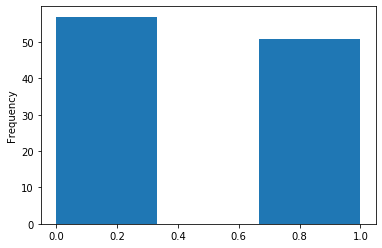

In [193]:
rep['water-project'].plot(kind='hist', bins=3);

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns 

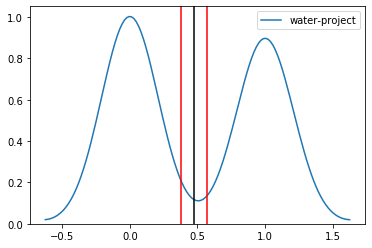

In [195]:
#kernel density estimte
sns.kdeplot(rep['water-project'])
plt.axvline(x=CI[1], color='r') 
plt.axvline(x=CI[2], color='r')
plt.axvline(x=CI[0], color='k'); #sample mean. we ar 95% sure that the population is between the red lines

In [196]:
"""
def CI_graph_func(data, confidence=0.95):
  CI = confidence_interval(sample_means)
  plt.axvline(x=CI[1], color='r') 
  plt.axvline(x=CI[2], color='r')
  plt.axvline(x=CI[0], color='k');
"""

"\ndef CI_graph_func(data, confidence=0.95):\n  CI = confidence_interval(sample_means)\n  plt.axvline(x=CI[1], color='r') \n  plt.axvline(x=CI[2], color='r')\n  plt.axvline(x=CI[0], color='k');\n"

# Interpret the confidence interval - what does it tell you about the data and its distribution?

In [0]:
#Based on the sample provided we are 95% confident that the population mean in between the red lines 
# in range between 0.377 and 0.568

In [198]:
CI

(0.4722222222222222, 0.3765480931771919, 0.5678963512672525)

In [199]:
#we can run a test:
ttest_1samp(rep['water-project'], 0.5) # we pick a random value, ie 0.5, which is inside our confidence interval
#the p value is higher than 0.05, which mean we fail to reject the null hypothesis. We cannot be sure that there is a significant difference between the population mean 
# and the sample mean 

Ttest_1sampResult(statistic=-0.5755600314869002, pvalue=0.5661210802319295)

In [200]:
#let's pick another value outside of our CI, ie 0.6
ttest_1samp(rep['water-project'], 0.6)
#p value is less than 0.05 meaning that we reject the nul hypothesis. It is highly unlikely that it happened by chance 

Ttest_1sampResult(statistic=-2.6475761448397392, pvalue=0.00933215226130283)

# Chi-squared tests:
Take a dataset that we have used in the past in class that has categorical variables. 
Pick two of those categorical variables and run a chi-squared tests on that data
1) By hand using Numpy
2) In a single line using Scipy

In [201]:
import pandas as pd
import numpy as np
column_headers = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
                  'Shucked weight', 'Viscera weight','Shell weight', 'Rings']
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'

#The headers were not showing properly, therefore we added: header = None and 
#replaced names with column_headers
abalone_df = pd.read_csv(data_url, header = None, names = column_headers, na_values='?')
print(abalone_df)


     Sex  Length  Diameter  ...  Viscera weight  Shell weight  Rings
0      M   0.455     0.365  ...          0.1010        0.1500     15
1      M   0.350     0.265  ...          0.0485        0.0700      7
2      F   0.530     0.420  ...          0.1415        0.2100      9
3      M   0.440     0.365  ...          0.1140        0.1550     10
4      I   0.330     0.255  ...          0.0395        0.0550      7
...   ..     ...       ...  ...             ...           ...    ...
4172   F   0.565     0.450  ...          0.2390        0.2490     11
4173   M   0.590     0.440  ...          0.2145        0.2605     10
4174   M   0.600     0.475  ...          0.2875        0.3080      9
4175   F   0.625     0.485  ...          0.2610        0.2960     10
4176   M   0.710     0.555  ...          0.3765        0.4950     12

[4177 rows x 9 columns]


In [202]:
abalone_df.describe(exclude='number')

,Sex
count,4177
unique,3
top,M
freq,1528


In [203]:
abalone_df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [204]:
#we are going to predict the age of abalone from its height 
#we are going to convert a numeric variable "Height" into a categorical 
abalone_df['Height'].describe()

count    4177.000000
mean        0.139516
std         0.041827
min         0.000000
25%         0.115000
50%         0.140000
75%         0.165000
max         1.130000
Name: Height, dtype: float64

In [205]:
#cut!
cut_points = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]
abalone_df['Height_cats'] = pd.cut(abalone_df['Height'], cut_points)
abalone_df['Height_cats'].value_counts().sort_index()

(0.0, 0.2]    4021
(0.2, 0.4]     152
(0.4, 0.6]       1
(0.6, 0.8]       0
(0.8, 1.0]       0
(1.0, 1.2]       1
Name: Height_cats, dtype: int64

In [206]:
abalone_df['Sex'].value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

In [207]:
#crostab
x_table = pd.crosstab(abalone_df['Sex'], abalone_df['Height_cats'], margins=True)
x_table

Height_cats,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(1.0, 1.2]",All
Sex,,,,,
F,1229,77,0,1,1307
I,1338,2,0,0,1340
M,1454,73,1,0,1528
All,4021,152,1,1,4175


In [208]:
#create a set of female counts 
f_counts = x_table.iloc[0][0:4].values
f_counts

array([1229,   77,    0,    1])

In [209]:
#create a set of male counts 
m_counts = x_table.iloc[1][0:4].values
m_counts

array([1338,    2,    0,    0])

In [210]:
#create a set of infant counts 
i_counts = x_table.iloc[2][0:4].values
i_counts

array([1454,   73,    1,    0])

# CHI-SQUARED STATISTIC WITH NUMPY

In [211]:
#EXPECTED VALUE CALCULATION
row_sums = x_table.iloc[0:3, 4].values # pulled out All rows
column_sums = x_table.iloc[3, 0:4].values # pulled out All column
print(row_sums)
column_sums

[1307 1340 1528]


array([4021,  152,    1,    1])

In [213]:
total = x_table.loc['All', 'All']
total

4175

In [218]:
#what does the expected distriution look like
print(expected[0])
print(expected[1])
x_table

[1.25878970e+03 4.75841916e+01 3.13053892e-01 3.13053892e-01]
[1.29057246e+03 4.87856287e+01 3.20958084e-01 3.20958084e-01]


Height_cats,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(1.0, 1.2]",All
Sex,,,,,
F,1229,77,0,1,1307
I,1338,2,0,0,1340
M,1454,73,1,0,1528
All,4021,152,1,1,4175


In [0]:
expected = []
for i in range(len(row_sums)):
  expected_row=[]
  for column in column_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)

In [221]:
#Chi squared is testing the comparison between observed(ie dependent) and expected (ie independent) and determining if this difference could have happened by chance 
#expected = nul hypothesis 
observed  = pd.crosstab(abalone_df['Sex'], abalone_df['Height_cats']).values
observed 

array([[1229,   77,    0,    1],
       [1338,    2,    0,    0],
       [1454,   73,    1,    0]])

In [223]:
#array broadcasting: arithmetic using numpy arrays 
chi_squared_stats = ((observed-expected)**2/(expected)).sum()
chi_squared_stats 

75.06149319687178

In [226]:
#degrees of freedom (num_rows - 1)*(num_columns - 1)
dof = (len(row_sums -1 )*(len(column_sums - 1)))
dof

12

In [0]:
#Run the Chi squared 

In [228]:
stats.chi2_contingency(observed)  #it gives us a tuple with 4 values: 1) chi squared stat, 2) pvalue; 3) degreed of freedom, 3) expected value array

(75.06149319687178,
 3.728044900793477e-14,
 6,
 array([[1.25878970e+03, 4.75841916e+01, 3.13053892e-01, 3.13053892e-01],
        [1.29057246e+03, 4.87856287e+01, 3.20958084e-01, 3.20958084e-01],
        [1.47163784e+03, 5.56301796e+01, 3.65988024e-01, 3.65988024e-01]]))

In [0]:
#P value =  3.728044900793477e-14 < 0.05. Therefore, we reject this null hypothesis 

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)